In [1]:
import numpy as np
from fipy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('figure', figsize=[10, 8])
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Exit probability as PDE

Consider the SDE
$$
  d X_t = \theta( \mu  - X_t) dt + \sigma d W_t,
$$
and the reachability problem for a level $x > \mu + \lambda$ from below for $\lambda > 0$. 

Let $V(t,x)$ be the probability of hitting $0$, it satisfies the HJB equation

$$
  0 = \mathbb E_x dV(t, X_t) = \left( \frac{\partial V}{\partial t} + \theta (\mu -  x) \frac{\partial V}{\partial x} + \frac{\sigma^2}{2} \frac{\partial^2 V}{\partial x^2} \right) dt,
$$
so it follows that $V$ satisfies the PDE
$$
    \frac{\partial V}{\partial t} = \theta (x - \mu) \frac{\partial V}{\partial x} - \frac{\sigma^2}{2} \frac{\partial^2 V}{\partial x^2} \\
    V(t,\mu + \lambda) = 1 \\
    v(0,x) = 0
$$
on the region $[0,T] \times [-\infty, \mu + \lambda]$. Time revarsal yields 
$$
    \frac{\partial V}{\partial t} = \frac{\sigma^2}{2} \frac{\partial^2 V}{\partial x^2} -\theta (x - \mu) \frac{\partial V}{\partial x}   \\
    V(0,\mu + \lambda) = 1 \\
    v(0,x) = 0
$$
on the domain $[0, \infty] \times [-\infty, \mu + \lambda]$.

We can rewrite the PDE in the FiPy standard format as

$$ 
  \frac{\partial V}{\partial t} = \left[\nabla \cdot \left(\frac{\sigma^2}{2} \nabla \right) \right] V - \nabla \cdot \left( \theta (x - \mu) V \right)  + \mu V
$$


**Remark:** We can redefine $W = V-1$ to get a homogeneous Direchlet boundary condition and initial condition -1.

In [2]:
# Solve PDE problem
def solve_pde(xmin,   # domain min
              xmax,    # domain max
              Tmax,    # time max
              theta=1,   # dynamics drift
              mu=0,      # dynamics stable level
              sigma=1,   # dynamics noise
              dx=0.01,   # space discretization
              dt=0.01,   # time discretization
              gbm=False):# state-dependent drift  

    mesh = Grid1D(dx=dx, nx=(xmax-xmin)/dx) + xmin
    Tsteps = int(Tmax/dt)+1
    
    x_face = mesh.faceCenters
    x_cell = mesh.cellCenters[0]  
    V = CellVariable(name="V", mesh=mesh, value=0.)

    # PDE
    if gbm:
        eq = TransientTerm(var=V) == (DiffusionTerm(coeff=float(sigma)*sigma/2, var=V) 
                                      -UpwindConvectionTerm(coeff=float(theta)*(x_face-float(mu)), var=V) 
                                      + V*(float(theta) - x_cell) )
    else:
        eq = TransientTerm(var=V) == (DiffusionTerm(coeff=float(sigma)*sigma/2, var=V) 
                                      -UpwindConvectionTerm(coeff=float(theta)*(x_face-float(mu)), var=V) 
                                      + V*float(theta) )

    
    # Boundary conditions
    V.constrain(1., mesh.facesRight)
    V.faceGrad.constrain([0.], mesh.facesLeft)

    # Solve by stepping in time
    sol = np.zeros((Tsteps, mesh.nx))
    for step in range(Tsteps):
        eq.solve(var=V, dt=dt)
        sol[step] = V.value
        
    X = mesh.cellCenters.value[0]
    T = dt * np.arange(Tsteps)
    return T, X, sol

# OU monotone

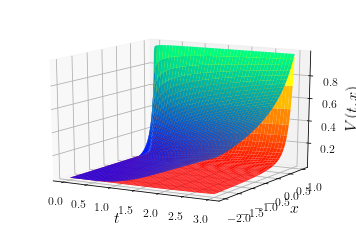

In [3]:
%matplotlib inline

T1, X1, Z1 = solve_pde(xmin=-2, xmax=1, Tmax=3, sigma=1)
TT1, XX1 = np.meshgrid(T1, X1)

T2, X2, Z2 = solve_pde(xmin=-2, xmax=1, Tmax=3, sigma=0.5)
TT2, XX2 = np.meshgrid(T2, X2)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf1 = ax.plot_surface(TT1, XX1, Z1.T, cmap=cm.winter, linewidth=0)
surf2 = ax.plot_surface(TT2, XX2, Z2.T, cmap=cm.autumn, linewidth=0)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_zlabel(r'$V(t,x)$')

ax.view_init(elev=15., azim=-60)

#plt.savefig('monotone.eps', format='eps')
plt.show()

# OU Non-monotone

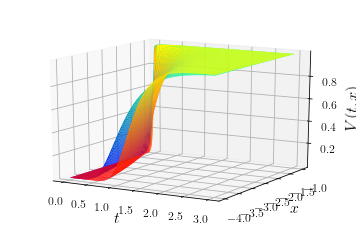

In [4]:
%matplotlib inline

T1, X1, Z1 = solve_pde(xmin=-4, xmax=-1, Tmax=3, sigma=1)
TT1, XX1 = np.meshgrid(T1, X1)

T2, X2, Z2 = solve_pde(xmin=-4, xmax=-1, Tmax=3, sigma=0.5)
TT2, XX2 = np.meshgrid(T2, X2)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf1 = ax.plot_surface(TT1, XX1, Z1.T, cmap=cm.winter, linewidth=0)
surf2 = ax.plot_surface(TT2, XX2, Z2.T, cmap=cm.autumn, linewidth=0)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_zlabel(r'$V(t,x)$')

ax.view_init(elev=15., azim=-60)

#plt.savefig('non-monotone.eps', format='eps')
plt.show()

# GBM monotone

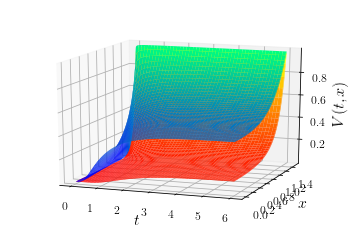

In [5]:
%matplotlib inline

T1, X1, Z1 = solve_pde(xmin=0, xmax=1.5, Tmax=6, mu=1, sigma=1, gbm=True)
TT1, XX1 = np.meshgrid(T1, X1)

T2, X2, Z2 = solve_pde(xmin=0, xmax=1.5, Tmax=6, mu=1, sigma=0.5, gbm=True)
TT2, XX2 = np.meshgrid(T2, X2)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf1 = ax.plot_surface(TT1, XX1, Z1.T, cmap=cm.winter, linewidth=0)
surf2 = ax.plot_surface(TT2, XX2, Z2.T, cmap=cm.autumn, linewidth=0)

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_zlabel(r'$V(t,x)$')

ax.view_init(elev=15., azim=-70)

plt.show()

# SDE simulation

Simulate trajectories and calculate statistics

In [6]:
def sim_sde(mu, sigma, x0, t):
    n = len(t)

    x = np.zeros(n)
    x[0] = x0

    for i in range(n - 1):
        dt = t[i+1] - t[i]
        dx = mu(t[i], x[i]) * dt + sigma(t[i], x[i]) * np.sqrt(dt) * np.random.randn()
        x[i + 1] = x[i] + dx
    return x

def sim_mc(mu, sigma, x0, t, num_sim):
    return [sim_sde(mu, sigma, x0, t) for i in range(num_sim)]

def sup(trajectory):
    r = np.zeros(len(trajectory))
    r[0] = trajectory[0]
    for i in range(1, len(trajectory)):
        r[i] = max(r[i-1], trajectory[i])
    return r

def sup_statistic(trajectories, l):
    '''calculate P(sup x >= l)'''

    ret = np.zeros(len(trajectories[0]))

    for sup_traj in map(sup, trajectories):
        fidx = np.argmax(sup_traj >= l)
        if fidx > 0:
            ret[fidx:] += 1

    ret /= len(trajectories)

    return ret

# Sample paths of OU and GBM plus supremum

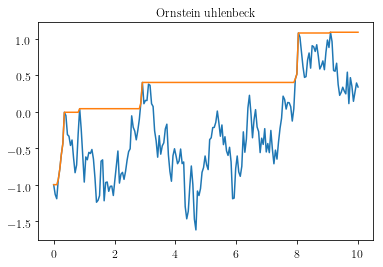

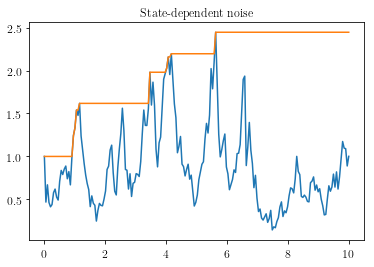

In [7]:
# OU dynamics
mu = lambda t,x: -x
sigma = lambda t,x: 1

t = np.linspace(0, 10, 200)
x = sim_sde(mu, sigma, -1, t)

sx = sup(x)

plt.plot(t, x)
plt.plot(t, sx)
plt.title("Ornstein uhlenbeck")
plt.show()

# GBP dynamics
mu = lambda t,x: (1-x)
sigma = lambda t,x: x

t = np.linspace(0, 10, 200)
x = sim_sde(mu, sigma, 1, t)

sx = sup(x)
plt.plot(t, x)
plt.plot(t, sx)
plt.title("State-dependent noise")
plt.show()

# Statistics of OU process

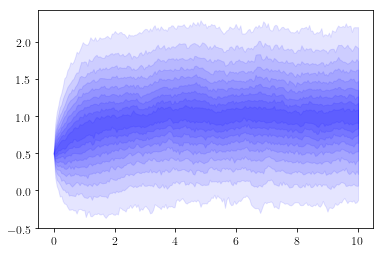

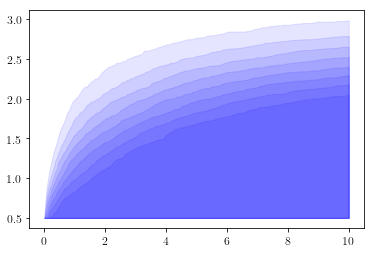

In [8]:
N = 1000
Tmax = 10
x0 = 0.5
t = np.linspace(0, Tmax, 200)

test = sim_mc(lambda t,x: 1-x,
              lambda t,x: 1,
              x0=x0,
              t=t,
              num_sim=N)

# Plot trajectory distribution
sort = np.sort(np.array(test), axis=0)
for level in np.arange(0.95, 0.5, -0.05):
    l0 = sort[int((1-level) * sort.shape[0])]
    l1 = sort[int(level * sort.shape[0]), : ]
    plt.fill_between(t, l1, l0, color='blue', alpha=0.1)

plt.show()

# Plot supremum distribution
sup_test = np.array([sup(traj) for traj in test])

sort = np.sort(sup_test, axis=0)
for level in np.arange(0.9, 0.1, -0.1):
    l1 = sort[int(level * sort.shape[0]), : ]
    plt.fill_between(t, l1, x0, color='blue', alpha=0.1)

plt.show()

# Supremum statistics of GBM-like process

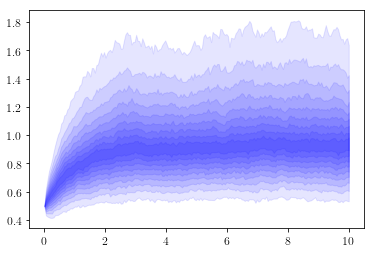

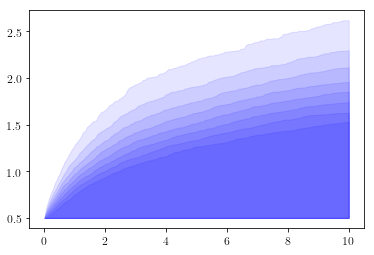

In [9]:
N = 1000
Tmax = 10
x0 = 0.5
t = np.linspace(0, Tmax, 200)

test = sim_mc(lambda t,x: (1 - x),
              lambda t,x: 0.5*x,
              x0=x0,
              t=t,
              num_sim=N)

# Plot trajectory distribution
sort = np.sort(np.array(test), axis=0)
for level in np.arange(0.95, 0.5, -0.05):
    l0 = sort[int((1-level) * sort.shape[0])]
    l1 = sort[int(level * sort.shape[0]), : ]
    plt.fill_between(t, l1, l0, color='blue', alpha=0.1)

plt.show()

# Plot supremum distribution
sup_test = np.array([sup(traj) for traj in test])

sort = np.sort(sup_test, axis=0)
for level in np.arange(0.9, 0.1, -0.1):
    l1 = sort[int(level * sort.shape[0]), : ]
    plt.fill_between(t, l1, x0, color='blue', alpha=0.1)

plt.show()